In [1]:
import pandas as pd
from clearml import Task
import numpy as np
import h5py
import os
from pathlib import Path
import re
from datetime import datetime
import dask.dataframe as dd
import gc

def find_latest_h5_file(task_id, base_dir="/scratch/clearml/offline_logs/"):
    """Find the latest h5 file for a given task_id"""
    base_path = Path(base_dir)
    
    pattern = f"metrics_{task_id}*.h5"
    matching_files = list(base_path.glob(pattern))
    
    if not matching_files:
        print(f"  No h5 file found for task {task_id}")
        return None
    
    if len(matching_files) == 1:
        print(f"  Found h5 file: {matching_files[0].name}")
        return matching_files[0]
    
    files_with_timestamps = []
    for file_path in matching_files:
        filename = file_path.name
        timestamp_match = re.search(f"metrics_{task_id}_(.+)\\.h5", filename)
        if timestamp_match:
            timestamp_str = timestamp_match.group(1)
            try:
                timestamp = float(timestamp_str)
            except ValueError:
                try:
                    timestamp = datetime.strptime(timestamp_str, "%Y%m%d_%H%M%S").timestamp()
                except:
                    timestamp = 0
            files_with_timestamps.append((file_path, timestamp))
        else:
            files_with_timestamps.append((file_path, 0))
    
    latest_file = max(files_with_timestamps, key=lambda x: x[1])[0]
    print(f"  Multiple h5 files found, using latest: {latest_file.name}")
    return latest_file

def debug_h5_structure(h5_path):
    """Debug function to inspect h5 file structure"""
    print(f"\nDEBUGGING H5 FILE: {h5_path}")
    
    with h5py.File(h5_path, 'r') as f:
        def print_structure(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"Dataset: {name}")
                print(f"  Shape: {obj.shape}")
                print(f"  Dtype: {obj.dtype}")
                if obj.size < 10:
                    print(f"  Data preview: {obj[:]}")
                else:
                    print(f"  Data preview (first 5): {obj[:5]}")
        
        print("H5 File Structure:")
        f.visititems(print_structure)
        print(f"\nRoot level keys: {list(f.keys())}")

def read_h5_metrics(h5_path):
    """Read metrics from h5 file and return as structured dictionary"""
    metrics = {}
    
    with h5py.File(h5_path, 'r') as f:
        metric_names = set()
        for key in f.keys():
            if not key.endswith('_iterations'):
                metric_names.add(key)
        
        for metric_name in metric_names:
            iteration_key = f"{metric_name}_iterations"
            
            if metric_name in f:
                values = f[metric_name][:]
                iterations = f[iteration_key][:] if iteration_key in f else None
                
                metrics[metric_name] = {
                    'values': values,
                    'iterations': iterations
                }
    
    return metrics

def download_and_process_tasks_from_h5_normalized(tag, experiment_name, base_dir="/scratch/clearml/offline_logs/", 
                                                   debug_first=True, batch_size=20, 
                                                   metadata_path=None, timeseries_path=None):
    """Download tasks and save as normalized tables: metadata + timeseries"""
    print(f"DOWNLOADING TASKS FOR {experiment_name}: {tag}")
    tasks = Task.get_tasks(project_name="oho", tags=[tag], allow_archived=False)
    print(f"Found {len(tasks)} tasks (excluding archived)")
    
    if not metadata_path or not timeseries_path:
        raise ValueError("Both metadata_path and timeseries_path are required")
    
    print(f"Will save metadata to: {metadata_path}")
    print(f"Will save timeseries to: {timeseries_path}")
    
    # Create directories if they don't exist
    os.makedirs(os.path.dirname(metadata_path), exist_ok=True)
    os.makedirs(os.path.dirname(timeseries_path), exist_ok=True)
    
    # Remove existing files
    if os.path.exists(metadata_path):
        os.remove(metadata_path)
    if os.path.exists(timeseries_path):
        os.remove(timeseries_path)
    
    h5_files_found = 0
    h5_files_missing = 0
    total_metadata_rows = 0
    total_timeseries_rows = 0
    
    metadata_rows = []
    
    for batch_start in range(0, len(tasks), batch_size):
        batch_end = min(batch_start + batch_size, len(tasks))
        batch_tasks = tasks[batch_start:batch_end]
        print(f"\nProcessing batch {batch_start + 1}-{batch_end}/{len(tasks)}")
        
        timeseries_rows = []
        
        for idx, task in enumerate(batch_tasks):
            task_id = task.id
            task_name = task.name
            
            # Metadata row (one per task)
            metadata_row = {"task_id": task_id, "task_name": task_name}
            params = task.get_parameters() or {}
            for key, value in params.items():
                if any(x in key for x in ["learning_rate", "optimizer/_type", "seed/global_seed"]):
                    metadata_row[key] = value
            
            h5_path = find_latest_h5_file(task_id, base_dir)
            
            if h5_path is None:
                h5_files_missing += 1
                metadata_rows.append(metadata_row)
                continue
            
            h5_files_found += 1
            
            if debug_first and h5_files_found == 1:
                debug_h5_structure(h5_path)
            
            try:
                metrics = read_h5_metrics(h5_path)
                
                # Separate scalar (final_*) from timeseries
                scalar_metrics = {}
                timeseries_metrics = {}
                
                for metric_name, metric_data in metrics.items():
                    values = metric_data['values']
                    iterations = metric_data['iterations']
                    
                    if metric_name.startswith('final_'):
                        # Add to metadata
                        scalar_metrics[f"metric/{metric_name}"] = values[0] if len(values) > 0 else np.nan
                    elif iterations is not None and len(values) == len(iterations):
                        timeseries_metrics[metric_name] = metric_data
                
                # Add scalar metrics to metadata row
                metadata_row.update(scalar_metrics)
                metadata_rows.append(metadata_row)
                
                # Create timeseries rows (many per task)
                if timeseries_metrics:
                    ref_metric = list(timeseries_metrics.keys())[0]
                    iterations = timeseries_metrics[ref_metric]['iterations']
                    
                    for iter_idx, iteration in enumerate(iterations):
                        ts_row = {
                            "task_id": task_id,
                            "iteration": int(iteration)
                        }
                        
                        for metric_name, metric_data in timeseries_metrics.items():
                            if iter_idx < len(metric_data['values']):
                                ts_row[f"metric/{metric_name}"] = metric_data['values'][iter_idx]
                        
                        timeseries_rows.append(ts_row)
                    
            except Exception as e:
                print(f"  ERROR reading h5 file: {e}")
                import traceback
                traceback.print_exc()
                h5_files_missing += 1
                metadata_rows.append(metadata_row)
        
        # Save timeseries batch
        if timeseries_rows:
            ts_batch_df = pd.DataFrame(timeseries_rows)
            total_timeseries_rows += len(ts_batch_df)
            
            if batch_start == 0:
                ts_batch_df.to_parquet(timeseries_path, index=False)
            else:
                existing_ts = pd.read_parquet(timeseries_path)
                combined_ts = pd.concat([existing_ts, ts_batch_df], ignore_index=True)
                combined_ts.to_parquet(timeseries_path, index=False)
            
            print(f"  Saved timeseries batch ({len(ts_batch_df)} rows)")
            
            del timeseries_rows
            del ts_batch_df
            if batch_start > 0:
                del existing_ts
                del combined_ts
            gc.collect()
    
    # Save all metadata at once (only 300 rows, no need to batch)
    if metadata_rows:
        metadata_df = pd.DataFrame(metadata_rows)
        metadata_df.to_parquet(metadata_path, index=False)
        total_metadata_rows = len(metadata_df)
        print(f"\nSaved metadata ({total_metadata_rows} rows) to {metadata_path}")
    
    print(f"\n=== SUMMARY ===")
    print(f"Total tasks: {len(tasks)}")
    print(f"H5 files found: {h5_files_found}")
    print(f"H5 files missing: {h5_files_missing}")
    print(f"Total metadata rows: {total_metadata_rows}")
    print(f"Total timeseries rows: {total_timeseries_rows}")
    
    # Load as Dask DataFrames
    print(f"\nLoading as Dask DataFrames")
    df_metadata = dd.read_parquet(metadata_path)
    df_timeseries = dd.read_parquet(timeseries_path)
    
    print(f"\nMetadata DataFrame: {df_metadata.npartitions} partitions")
    print(f"Columns: {df_metadata.columns.tolist()}")
    print(f"Sample:")
    print(df_metadata.head(5))
    
    print(f"\nTimeseries DataFrame: {df_timeseries.npartitions} partitions")
    print(f"Columns: {df_timeseries.columns.tolist()}")
    print(f"Sample:")
    print(df_timeseries.head(5))
    
    return df_metadata, df_timeseries



In [7]:

# Usage
df_metadata_exp1, df_timeseries_exp1 = download_and_process_tasks_from_h5_normalized(
    tag="opt: 796e8d6e1b5b4b388b8540676ce8ea8f", 
    experiment_name="Fixed LR",
    base_dir="/scratch/clearml/offline_logs/",
    debug_first=True,
    batch_size=20,
    metadata_path="/scratch/clearml/processed_data/fixed_lr_metadata.parquet",
    timeseries_path="/scratch/clearml/processed_data/fixed_lr_timeseries.parquet"
)


DOWNLOADING TASKS FOR Fixed LR: opt: 796e8d6e1b5b4b388b8540676ce8ea8f
Found 300 tasks (excluding archived)
Will save metadata to: /scratch/clearml/processed_data/fixed_lr_metadata.parquet
Will save timeseries to: /scratch/clearml/processed_data/fixed_lr_timeseries.parquet

Processing batch 1-20/300
  Found h5 file: metrics_8bd7f69dc21e46529760eefc8e6c3317.h5

DEBUGGING H5 FILE: /scratch/clearml/offline_logs/metrics_8bd7f69dc21e46529760eefc8e6c3317.h5
H5 File Structure:
Dataset: final_test_accuracy
  Shape: (1,)
  Dtype: float64
  Data preview: [0.69199991]
Dataset: final_test_accuracy_iterations
  Shape: (1,)
  Dtype: int32
  Data preview: [50000]
Dataset: final_test_loss
  Shape: (1,)
  Dtype: float64
  Data preview: [0.82570457]
Dataset: final_test_loss_iterations
  Shape: (1,)
  Dtype: int32
  Data preview: [50000]
Dataset: meta_gradient_norm
  Shape: (50000,)
  Dtype: float64
  Data preview (first 5): [0. 0. 0. 0. 0.]
Dataset: meta_gradient_norm_iterations
  Shape: (50000,)
  Dtype

In [2]:

# Usage
df_metadata_exp2, df_timeseries_exp2 = download_and_process_tasks_from_h5_normalized(
    tag="opt: be339c9b39694bcc8f4365b4a6f56c1b", 
    experiment_name="oho",
    base_dir="/scratch/clearml/offline_logs/",
    debug_first=True,
    batch_size=20,
    metadata_path="/scratch/clearml/processed_data/oho_metadata.parquet",
    timeseries_path="/scratch/clearml/processed_data/oho_timeseries.parquet"
)


DOWNLOADING TASKS FOR oho: opt: be339c9b39694bcc8f4365b4a6f56c1b
Found 80 tasks (excluding archived)
Will save metadata to: /scratch/clearml/processed_data/oho_metadata.parquet
Will save timeseries to: /scratch/clearml/processed_data/oho_timeseries.parquet

Processing batch 1-20/80
  Found h5 file: metrics_355575d222624c81971cca43c47590d0_20251009_194756.h5

DEBUGGING H5 FILE: /scratch/clearml/offline_logs/metrics_355575d222624c81971cca43c47590d0_20251009_194756.h5
H5 File Structure:
Dataset: final_test_accuracy
  Shape: (1,)
  Dtype: float64
  Data preview: [0.88990003]
Dataset: final_test_accuracy_iterations
  Shape: (1,)
  Dtype: int32
  Data preview: [50000]
Dataset: final_test_loss
  Shape: (1,)
  Dtype: float64
  Data preview: [0.30840552]
Dataset: final_test_loss_iterations
  Shape: (1,)
  Dtype: int32
  Data preview: [50000]
Dataset: meta_gradient_norm
  Shape: (50000,)
  Dtype: float64
  Data preview (first 5): [0.         2.32948709 4.36942863 8.61088371 7.71896029]
Dataset: 

In [3]:
# Usage
experiments = [
    # ("Fixed LR", df_metadata_exp1, df_timeseries_exp1),
    ("OHO", df_metadata_exp2, df_timeseries_exp2),
]


Processing OHO...

All configurations ranked by mean final test loss:
--------------------------------------------------------------------------------
Rank 1: LR0=0.001000, LR1=0.000010 | mean=0.315189, std=0.002639, n=20
Rank 2: LR0=0.010000, LR1=0.000010 | mean=0.315302, std=0.003255, n=20
Rank 3: LR0=0.000100, LR1=0.000010 | mean=0.315378, std=0.002701, n=20
Rank 4: LR0=0.100000, LR1=0.000010 | mean=0.318692, std=0.014773, n=20

********************************************************************************
BEST CONFIG: LR0=0.001000, LR1=0.000010
Mean final test loss: 0.315189
********************************************************************************

Best config statistics:
  Final losses: 20 tasks
  Effective LRs: 20 tasks


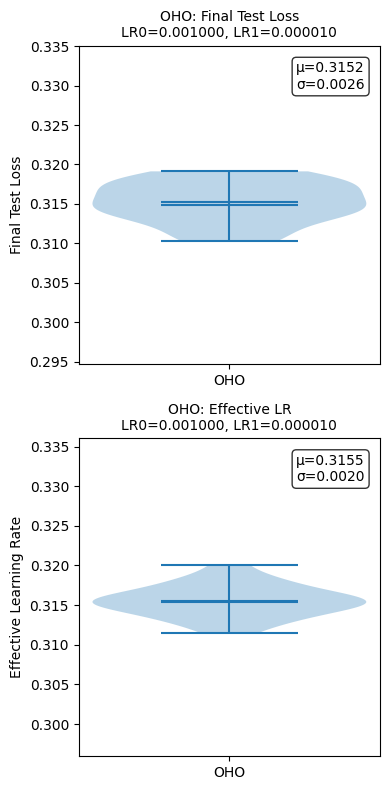

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def power_law(t, a, b, c):
    return a * (t + 1) ** (-b) + c

def plot_final_loss_and_effective_lr_violins(experiments):
    """
    Plot violin plots for final test loss and effective learning rate across experiments.
    Only uses tasks from the BEST learning rate configuration.
    
    Args:
        experiments: list of tuples (name, df_metadata, df_timeseries)
    """
    n_experiments = len(experiments)
    
    all_final_losses = []
    all_eff_lrs = []
    experiment_data = []
    
    for name, df_metadata, df_timeseries in experiments:
        print(f"\n{'='*60}")
        print(f"Processing {name}...")
        print(f"{'='*60}")
        
        metadata = df_metadata.compute()
        
        lr_cols = ['config/learners/0/optimizer/learning_rate/value', 
                   'config/learners/1/optimizer/learning_rate/value']
        
        # Group by LR config and get mean final test loss
        lr_summary = metadata.groupby(lr_cols)['metric/final_test_loss'].agg(['mean', 'std', 'count']).reset_index()
        lr_summary = lr_summary.sort_values('mean')
        
        print(f"\nAll configurations ranked by mean final test loss:")
        print("-" * 80)
        for rank, (_, row) in enumerate(lr_summary.iterrows(), start=1):
            lr0, lr1 = row[lr_cols[0]], row[lr_cols[1]]
            print(f"Rank {rank}: LR0={float(lr0):.6f}, LR1={float(lr1):.6f} | "
                f"mean={row['mean']:.6f}, std={row['std']:.6f}, n={int(row['count'])}")
        
        # Best config is the one with LOWEST final test loss
        best_config = lr_summary.iloc[0]
        best_lr0 = best_config[lr_cols[0]]
        best_lr1 = best_config[lr_cols[1]]
        config_str = f"LR0={float(best_lr0):.6f}, LR1={float(best_lr1):.6f}"
        
        print(f"\n{'*'*80}")
        print(f"BEST CONFIG: {config_str}")
        print(f"Mean final test loss: {best_config['mean']:.6f}")
        print(f"{'*'*80}")
        
        # Filter metadata to best config
        best_metadata = metadata[
            (metadata[lr_cols[0]] == best_lr0) & 
            (metadata[lr_cols[1]] == best_lr1)
        ]
        
        # Get final test losses for best config
        final_losses = best_metadata['metric/final_test_loss'].dropna().values
        best_task_ids = best_metadata['task_id'].values
        
        # Compute effective learning rates from test loss curves for best config tasks
        timeseries = df_timeseries.compute()
        eff_lrs = []
        
        for task_id in best_task_ids:
            task_data = timeseries[timeseries['task_id'] == task_id]
            if len(task_data) > 5 and 'metric/test_loss' in task_data.columns:
                try:
                    iterations = task_data['iteration'].values
                    test_losses = task_data['metric/test_loss'].dropna().values
                    if len(test_losses) > 5:
                        popt, _ = curve_fit(power_law, iterations[:len(test_losses)], test_losses,
                                          bounds=([0,0,0], [np.inf,np.inf,np.inf]), maxfev=2000)
                        eff_lrs.append(popt[1])
                except:
                    continue
        
        eff_lrs = np.array(eff_lrs)
        
        experiment_data.append({
            'name': name,
            'config': config_str,
            'final_losses': final_losses,
            'eff_lrs': eff_lrs
        })
        
        all_final_losses.extend(final_losses)
        all_eff_lrs.extend(eff_lrs)
        
        print(f"\nBest config statistics:")
        print(f"  Final losses: {len(final_losses)} tasks")
        print(f"  Effective LRs: {len(eff_lrs)} tasks")
    
    # Calculate shared y-axis limits
    final_loss_ylim = (min(all_final_losses) * 0.95, max(all_final_losses) * 1.05)
    eff_lr_ylim = (min(all_eff_lrs) * 0.95, max(all_eff_lrs) * 1.05)
    
    # Create plots
    fig, axes = plt.subplots(2, n_experiments, figsize=(4 * n_experiments, 8))
    if n_experiments == 1:
        axes = axes.reshape(2, 1)
    
    for i, data in enumerate(experiment_data):
        # Final test loss
        axes[0, i].violinplot([data['final_losses']], positions=[0], showmeans=True, showmedians=True)
        mean_val, std_val = np.mean(data['final_losses']), np.std(data['final_losses'])
        axes[0, i].text(0.95, 0.95, f'μ={mean_val:.4f}\nσ={std_val:.4f}', 
                       transform=axes[0, i].transAxes, va='top', ha='right',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        axes[0, i].set_title(f"{data['name']}: Final Test Loss\n{data['config']}", fontsize=10)
        axes[0, i].set_ylabel("Final Test Loss")
        axes[0, i].set_xticks([0])
        axes[0, i].set_xticklabels([data['name']])
        axes[0, i].set_ylim(final_loss_ylim)
        
        # Effective learning rate
        if len(data['eff_lrs']) > 0:
            axes[1, i].violinplot([data['eff_lrs']], positions=[0], showmeans=True, showmedians=True)
            mean_val, std_val = np.mean(data['eff_lrs']), np.std(data['eff_lrs'])
            axes[1, i].text(0.95, 0.95, f'μ={mean_val:.4f}\nσ={std_val:.4f}', 
                           transform=axes[1, i].transAxes, va='top', ha='right',
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            axes[1, i].set_ylim(eff_lr_ylim)
        else:
            axes[1, i].text(0.5, 0.5, "No Data", ha="center", va="center", 
                           transform=axes[1, i].transAxes)
        
        axes[1, i].set_title(f"{data['name']}: Effective LR\n{data['config']}", fontsize=10)
        axes[1, i].set_ylabel("Effective Learning Rate")
        axes[1, i].set_xticks([0])
        axes[1, i].set_xticklabels([data['name']])
    
    plt.tight_layout()
    plt.show()



plot_final_loss_and_effective_lr_violins(experiments)


Processing OHO...
  Best config: LR0=0.001000, LR1=0.000010
  Averaged power law params: a=7.0902, b=0.3155, c=0.0447
  Number of tasks used: 20


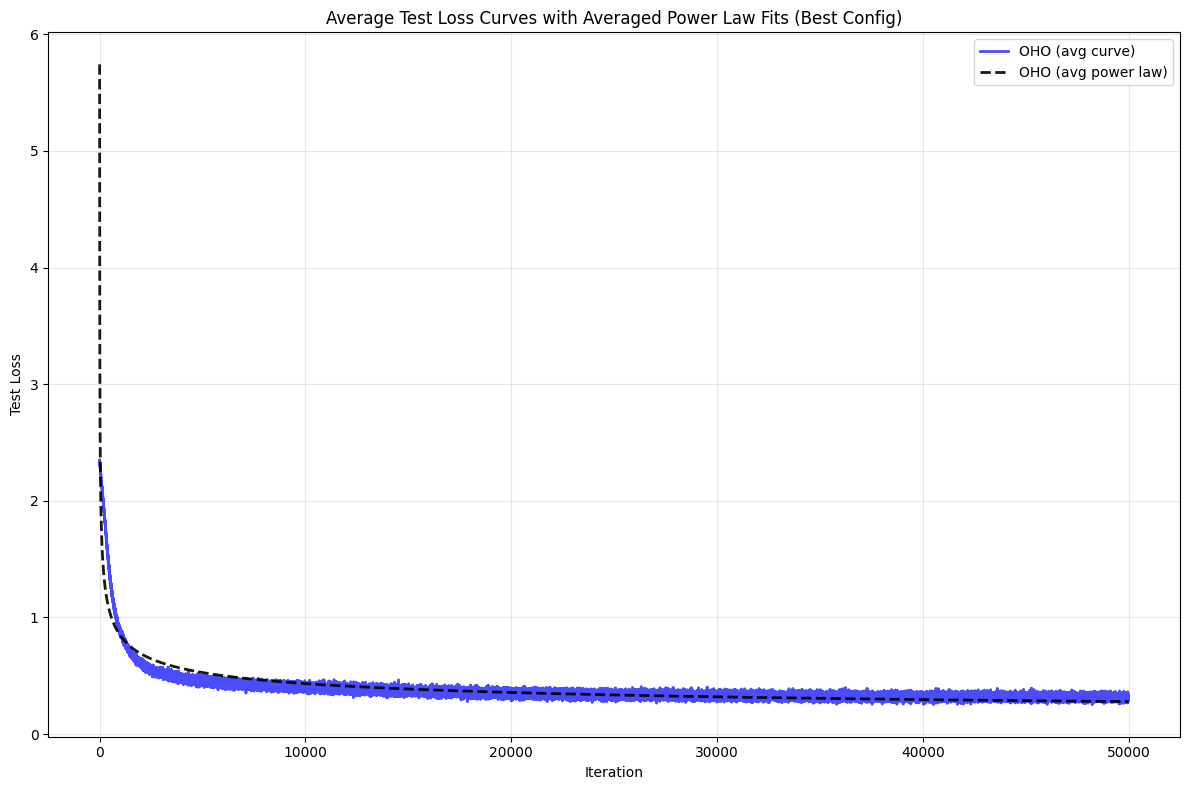

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def power_law(t, a, b, c):
    return a * (t + 1) ** (-b) + c

def plot_average_test_loss_curves_with_powerlaw(experiments):
    """
    Plot average test loss curves with averaged power law fits.
    Fits power law to each task individually, then averages the parameters.
    
    Args:
        experiments: list of tuples (name, df_metadata, df_timeseries)
    """
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    
    for idx, (name, df_metadata, df_timeseries) in enumerate(experiments):
        print(f"\nProcessing {name}...")
        color = colors[idx % len(colors)]
        
        metadata = df_metadata.compute()
        
        # Find best config
        lr_cols = ['config/learners/0/optimizer/learning_rate/value', 
                   'config/learners/1/optimizer/learning_rate/value']
        lr_summary = metadata.groupby(lr_cols)['metric/final_test_loss'].mean().reset_index()
        lr_summary = lr_summary.sort_values('metric/final_test_loss')
        best_config = lr_summary.iloc[0]
        best_lr0 = best_config[lr_cols[0]]
        best_lr1 = best_config[lr_cols[1]]
        
        print(f"  Best config: LR0={float(best_lr0):.6f}, LR1={float(best_lr1):.6f}")
        
        # Filter to best config
        best_metadata = metadata[
            (metadata[lr_cols[0]] == best_lr0) & 
            (metadata[lr_cols[1]] == best_lr1)
        ]
        best_task_ids = best_metadata['task_id'].values
        
        # Get timeseries for best config
        timeseries = df_timeseries.compute()
        best_timeseries = timeseries[timeseries['task_id'].isin(best_task_ids)]
        
        # Compute average test loss curve
        avg_curve = best_timeseries.groupby('iteration')['metric/test_loss'].mean()
        iterations = avg_curve.index.values
        avg_test_losses = avg_curve.values
        
        # Fit power law to each individual task and collect parameters
        power_law_params = []
        for task_id in best_task_ids:
            task_data = timeseries[timeseries['task_id'] == task_id]
            if len(task_data) > 5:
                try:
                    task_iterations = task_data['iteration'].values
                    task_losses = task_data['metric/test_loss'].dropna().values
                    if len(task_losses) > 5:
                        popt, _ = curve_fit(power_law, task_iterations[:len(task_losses)], task_losses,
                                          bounds=([0,0,0], [np.inf,np.inf,np.inf]), maxfev=2000)
                        power_law_params.append(popt)
                except:
                    continue
        
        if power_law_params:
            # Average the power law parameters
            avg_a = np.mean([p[0] for p in power_law_params])
            avg_b = np.mean([p[1] for p in power_law_params])
            avg_c = np.mean([p[2] for p in power_law_params])
            
            print(f"  Averaged power law params: a={avg_a:.4f}, b={avg_b:.4f}, c={avg_c:.4f}")
            print(f"  Number of tasks used: {len(power_law_params)}")
            
            # Generate power law curve using averaged parameters
            fitted_curve = power_law(iterations, avg_a, avg_b, avg_c)
            
            # Plot both
            ax.plot(iterations, avg_test_losses, color=color, linewidth=2, alpha=0.7, 
                   label=f'{name} (avg curve)', linestyle='-')
            ax.plot(iterations, fitted_curve, color='black', linewidth=2, alpha=0.9,
                   label=f'{name} (avg power law)', linestyle='--')
        else:
            print(f"  Failed to fit power laws")
            ax.plot(iterations, avg_test_losses, color=color, linewidth=2, 
                   label=f'{name} (avg curve)')
    
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Test Loss')
    ax.set_title('Average Test Loss Curves with Averaged Power Law Fits (Best Config)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



plot_average_test_loss_curves_with_powerlaw(experiments)


Processing OHO...
  Best config: LR0=0.001000, LR1=0.000010
  Number of seeds: 20


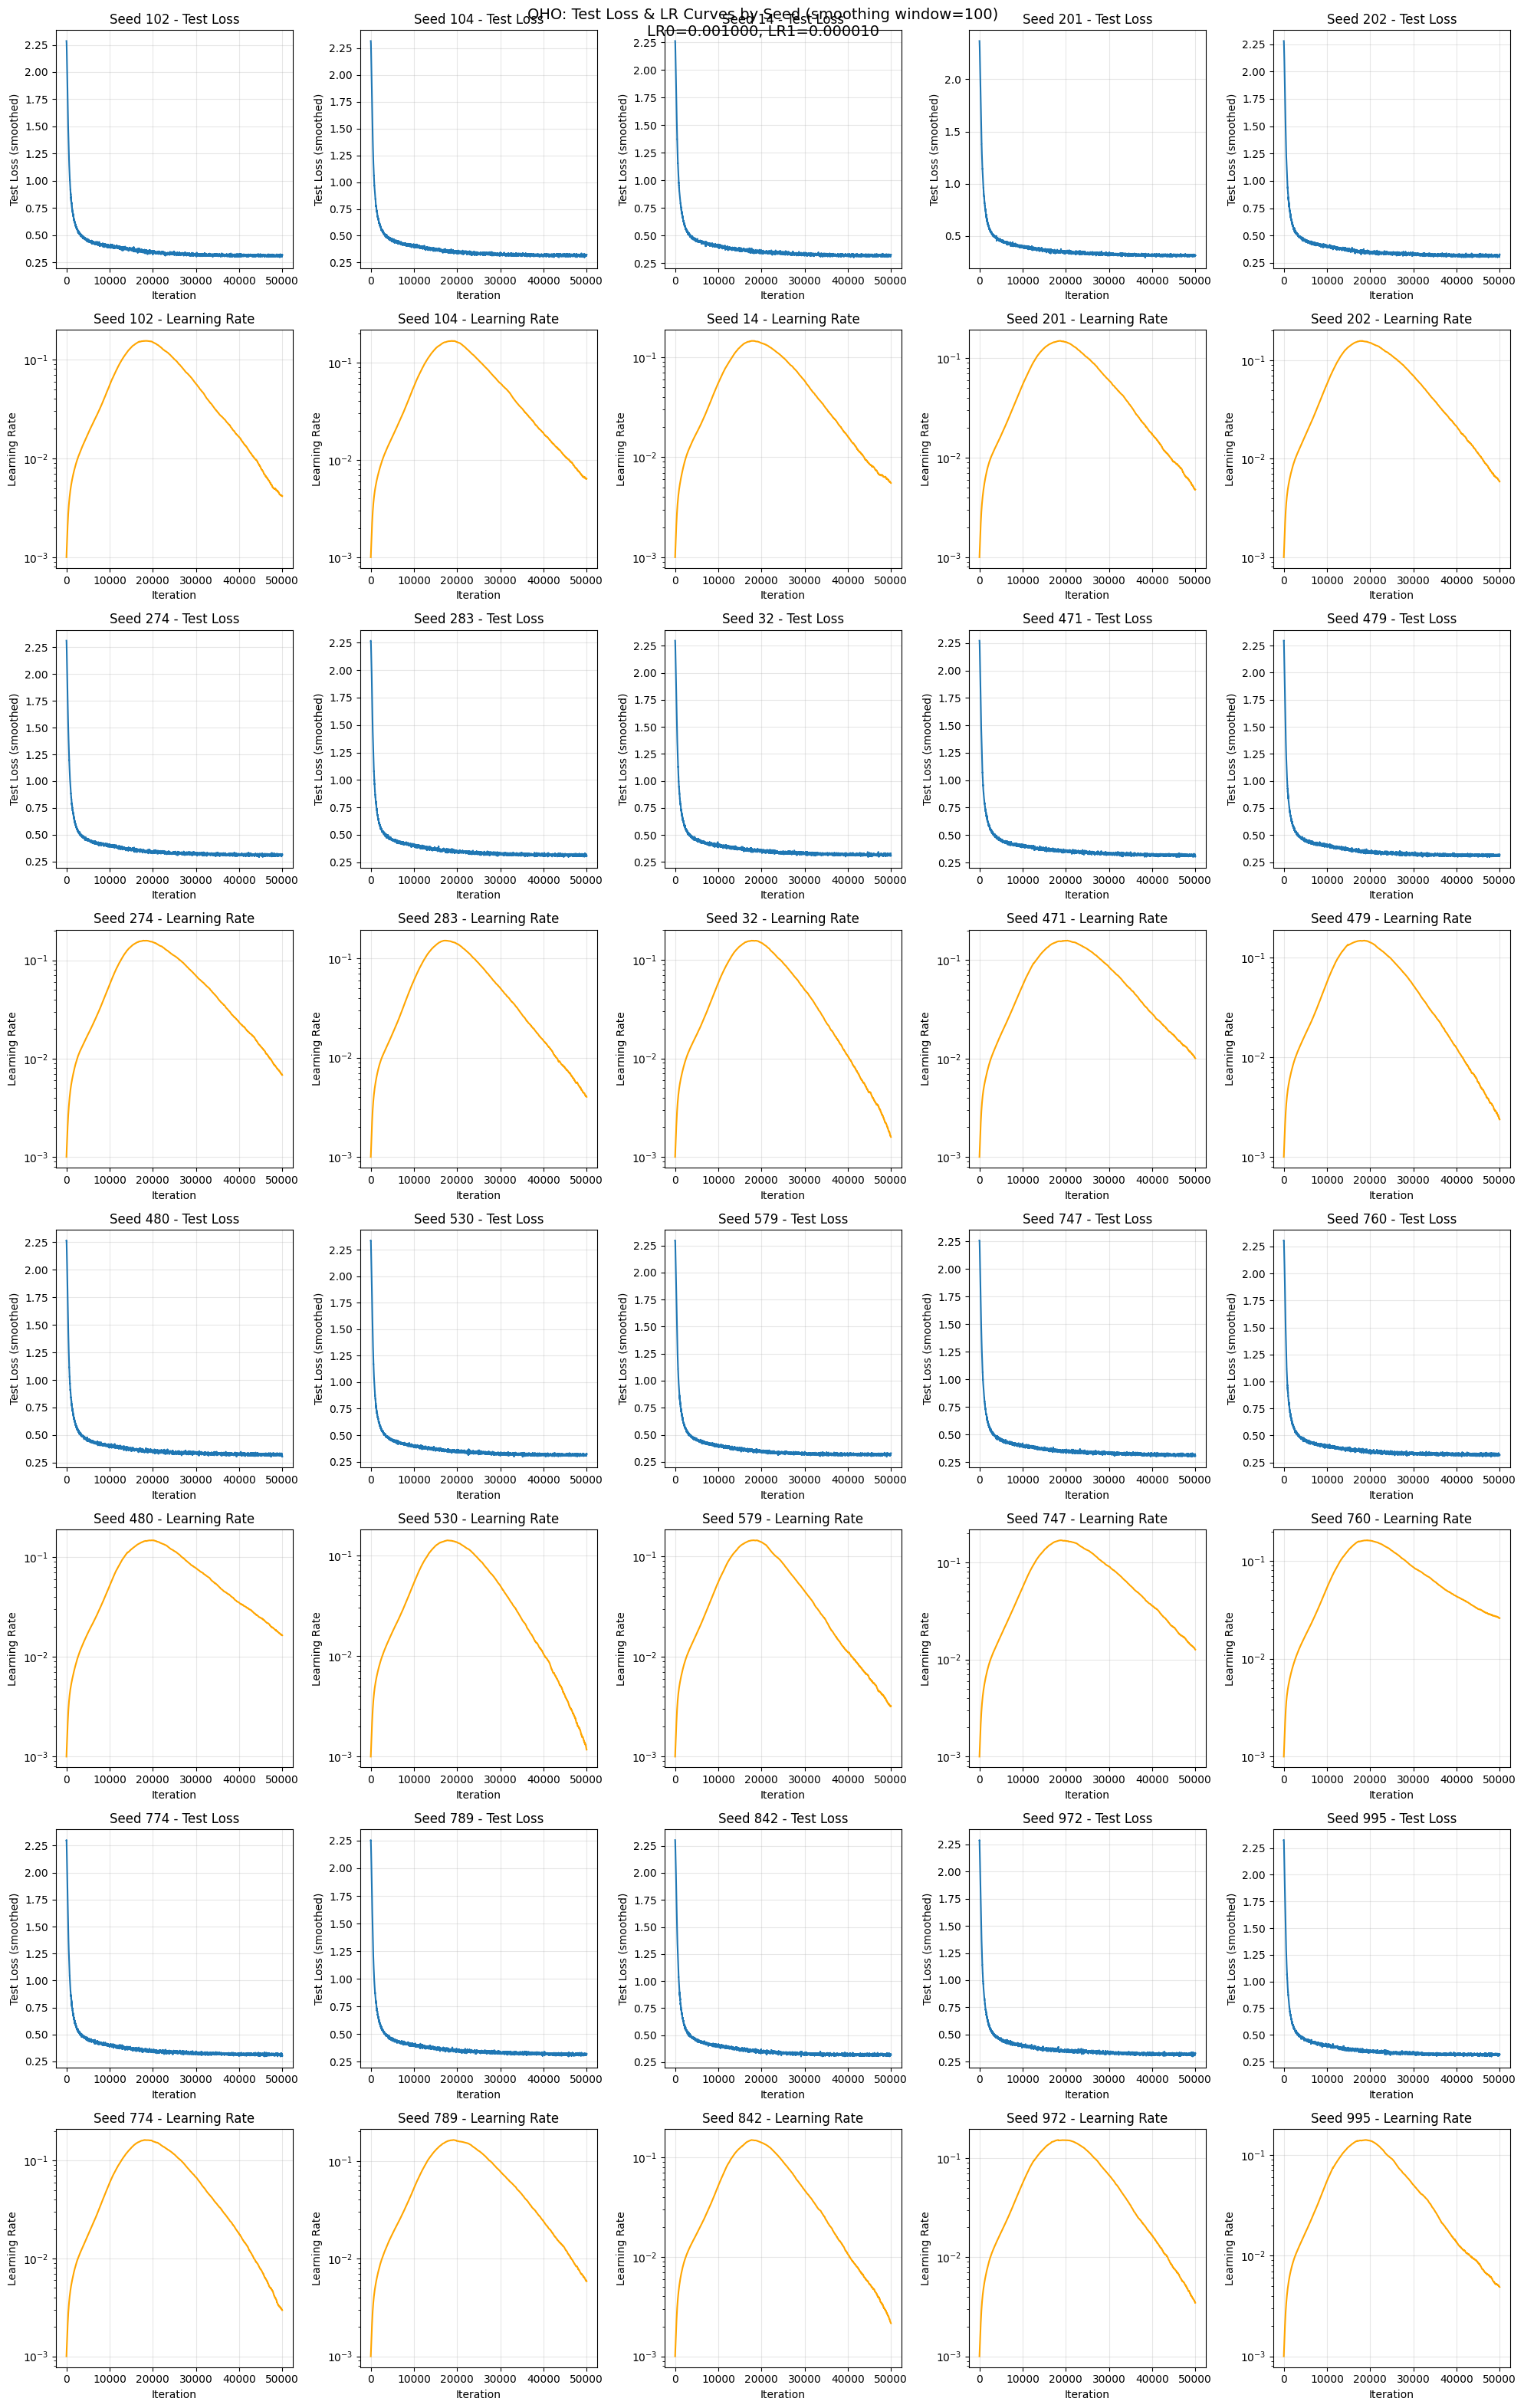

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter1d

def plot_test_loss_and_lr_curves_by_seed(experiments, smooth_window=100):
    """
    Plot smoothed test loss curves and learning rate curves for each seed individually.
    
    Args:
        experiments: list of tuples (name, df_metadata, df_timeseries)
        smooth_window: window size for smoothing
    """
    for name, df_metadata, df_timeseries in experiments:
        print(f"\nProcessing {name}...")
        
        metadata = df_metadata.compute()
        
        # Find best config
        lr_cols = ['config/learners/0/optimizer/learning_rate/value', 
                   'config/learners/1/optimizer/learning_rate/value']
        lr_summary = metadata.groupby(lr_cols)['metric/final_test_loss'].mean().reset_index()
        lr_summary = lr_summary.sort_values('metric/final_test_loss')
        best_config = lr_summary.iloc[0]
        best_lr0 = best_config[lr_cols[0]]
        best_lr1 = best_config[lr_cols[1]]
        
        print(f"  Best config: LR0={float(best_lr0):.6f}, LR1={float(best_lr1):.6f}")
        
        # Filter to best config
        best_metadata = metadata[
            (metadata[lr_cols[0]] == best_lr0) & 
            (metadata[lr_cols[1]] == best_lr1)
        ]
        
        # Get timeseries for best config
        timeseries = df_timeseries.compute()
        best_task_ids = best_metadata['task_id'].values
        best_timeseries = timeseries[timeseries['task_id'].isin(best_task_ids)]
        
        # Merge with metadata to get seeds
        best_timeseries_with_seed = best_timeseries.merge(
            best_metadata[['task_id', 'config/seed/global_seed']], 
            on='task_id'
        )
        
        # Get unique seeds
        seeds = sorted(best_timeseries_with_seed['config/seed/global_seed'].unique())
        print(f"  Number of seeds: {len(seeds)}")
        
        # Create subplots - 2 rows (test loss + LR) per seed
        n_seeds = len(seeds)
        n_cols = 5
        n_rows = ((n_seeds + n_cols - 1) // n_cols) * 2  # 2 rows per seed group
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
        axes = axes.reshape(n_rows, n_cols)
        
        # Plot test loss and LR curve for each seed
        for idx, seed in enumerate(seeds):
            col = idx % n_cols
            row_base = (idx // n_cols) * 2
            
            seed_data = best_timeseries_with_seed[
                best_timeseries_with_seed['config/seed/global_seed'] == seed
            ].sort_values('iteration')
            
            iterations = seed_data['iteration'].values
            test_losses = seed_data['metric/test_loss'].values
            
            # Smooth test loss
            smoothed_test_losses = uniform_filter1d(test_losses, size=smooth_window)
            
            # Plot test loss
            axes[row_base, col].plot(iterations, smoothed_test_losses, linewidth=1.5)
            axes[row_base, col].set_xlabel('Iteration')
            axes[row_base, col].set_ylabel('Test Loss (smoothed)')
            axes[row_base, col].set_title(f'Seed {int(seed)} - Test Loss')
            axes[row_base, col].grid(True, alpha=0.3)
            
            # Plot learning rate
            if 'metric/train_learning_rate' in seed_data.columns:
                learning_rates = seed_data['metric/train_learning_rate'].values
                axes[row_base + 1, col].plot(iterations, learning_rates, linewidth=1.5, color='orange')
                axes[row_base + 1, col].set_xlabel('Iteration')
                axes[row_base + 1, col].set_ylabel('Learning Rate')
                axes[row_base + 1, col].set_title(f'Seed {int(seed)} - Learning Rate')
                axes[row_base + 1, col].grid(True, alpha=0.3)
                axes[row_base + 1, col].set_yscale('log')
            else:
                axes[row_base + 1, col].text(0.5, 0.5, 'No LR data', 
                                            ha='center', va='center',
                                            transform=axes[row_base + 1, col].transAxes)
                axes[row_base + 1, col].set_title(f'Seed {int(seed)} - Learning Rate')
        
        # Hide unused subplots
        total_used = ((n_seeds + n_cols - 1) // n_cols) * 2
        for row in range(total_used, n_rows):
            for col in range(n_cols):
                axes[row, col].axis('off')
        
        # Hide unused columns in last row group
        last_group_start = (len(seeds) // n_cols) * 2
        used_in_last_group = len(seeds) % n_cols
        if used_in_last_group > 0:
            for col in range(used_in_last_group, n_cols):
                axes[last_group_start, col].axis('off')
                axes[last_group_start + 1, col].axis('off')
        
        fig.suptitle(f'{name}: Test Loss & LR Curves by Seed (smoothing window={smooth_window})\n'
                    f'LR0={float(best_lr0):.6f}, LR1={float(best_lr1):.6f}', 
                    fontsize=14)
        plt.tight_layout()
        plt.show()


plot_test_loss_and_lr_curves_by_seed(experiments, smooth_window=100)

/tmp/ipykernel_104352/1164612379.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20')



Processing OHO...
Best config: LR0=0.001000, LR1=0.000010


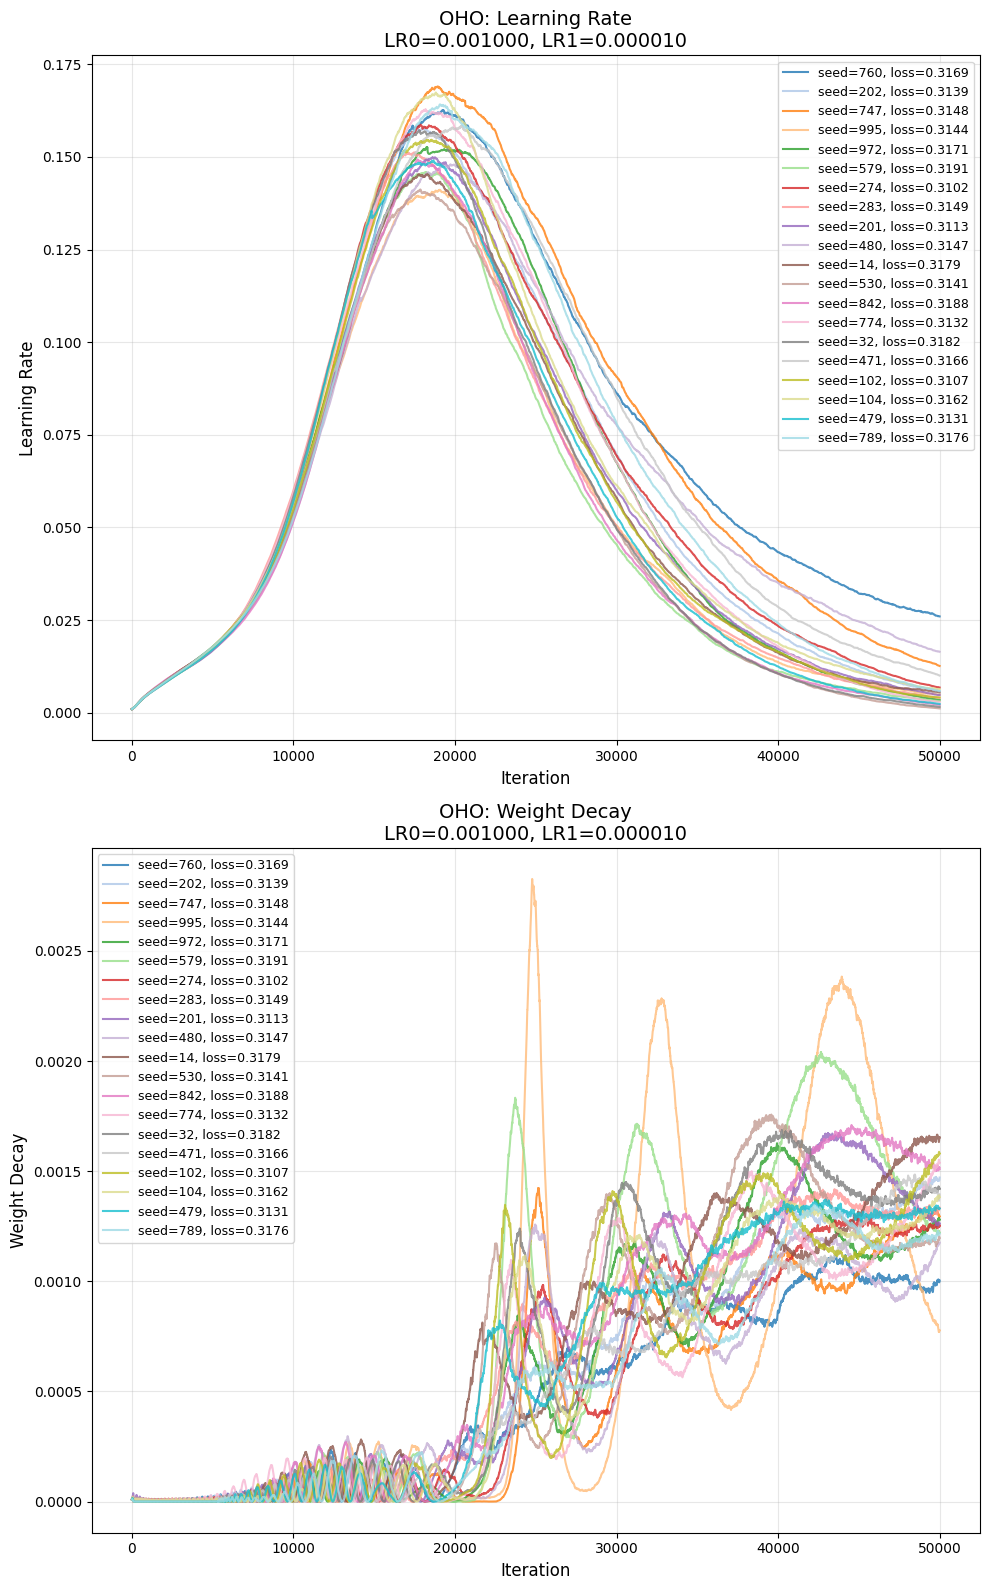

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_hyperparameters_for_best_config(experiments):
    """
    Plot learning rates and weight decays over iterations for the best configuration.
    All seeds plotted on same graph with seed labels and final test loss.
    
    Args:
        experiments: list of tuples (name, df_metadata, df_timeseries)
    """
    n_experiments = len(experiments)
    fig, axes = plt.subplots(2, n_experiments, figsize=(10 * n_experiments, 16))
    if n_experiments == 1:
        axes = axes.reshape(2, 1)
    
    # Create distinct colormap
    cmap = plt.cm.get_cmap('tab20')
    
    for exp_idx, (name, df_metadata, df_timeseries) in enumerate(experiments):
        print(f"\nProcessing {name}...")
        
        metadata = df_metadata.compute()
        timeseries = df_timeseries.compute()
        
        lr_cols = ['config/learners/0/optimizer/learning_rate/value', 
                   'config/learners/1/optimizer/learning_rate/value']
        
        # Find best configuration
        lr_summary = metadata.groupby(lr_cols)['metric/final_test_loss'].agg(['mean']).reset_index()
        lr_summary = lr_summary.sort_values('mean')
        best_config = lr_summary.iloc[0]
        best_lr0 = best_config[lr_cols[0]]
        best_lr1 = best_config[lr_cols[1]]
        
        print(f"Best config: LR0={float(best_lr0):.6f}, LR1={float(best_lr1):.6f}")
        
        # Filter to best config tasks
        best_metadata = metadata[
            (metadata[lr_cols[0]] == best_lr0) & 
            (metadata[lr_cols[1]] == best_lr1)
        ]
        
        # Plot learning rates and weight decays for each seed
        for color_idx, (_, row) in enumerate(best_metadata.iterrows()):
            task_id = row['task_id']
            seed = row['config/seed/global_seed']
            final_loss = row['metric/final_test_loss']
            
            task_data = timeseries[timeseries['task_id'] == task_id].sort_values('iteration')
            
            if len(task_data) > 0:
                iterations = task_data['iteration'].values
                label = f'seed={seed}, loss={final_loss:.4f}'
                color = cmap(color_idx % 20)
                
                # Learning rate
                if 'metric/train_learning_rate' in task_data.columns:
                    lrs = task_data['metric/train_learning_rate'].values
                    axes[0, exp_idx].plot(iterations, lrs, alpha=0.8, linewidth=1.5, label=label, color=color)
                
                # Weight decay
                if 'metric/train_weight_decay' in task_data.columns:
                    wds = task_data['metric/train_weight_decay'].values
                    axes[1, exp_idx].plot(iterations, wds, alpha=0.8, linewidth=1.5, label=label, color=color)
        
        # Format learning rate plot
        axes[0, exp_idx].set_title(f"{name}: Learning Rate\nLR0={float(best_lr0):.6f}, LR1={float(best_lr1):.6f}", fontsize=14)
        axes[0, exp_idx].set_xlabel("Iteration", fontsize=12)
        axes[0, exp_idx].set_ylabel("Learning Rate", fontsize=12)
        axes[0, exp_idx].grid(True, alpha=0.3)
        axes[0, exp_idx].legend(fontsize=9, loc='best')
        
        # Format weight decay plot
        axes[1, exp_idx].set_title(f"{name}: Weight Decay\nLR0={float(best_lr0):.6f}, LR1={float(best_lr1):.6f}", fontsize=14)
        axes[1, exp_idx].set_xlabel("Iteration", fontsize=12)
        axes[1, exp_idx].set_ylabel("Weight Decay", fontsize=12)
        axes[1, exp_idx].grid(True, alpha=0.3)
        axes[1, exp_idx].legend(fontsize=9, loc='best')
    
    plt.tight_layout()
    plt.show()

plot_hyperparameters_for_best_config(experiments)




Processing OHO...
  Best config: LR0=0.001000, LR1=0.000010
  Number of seeds: 20


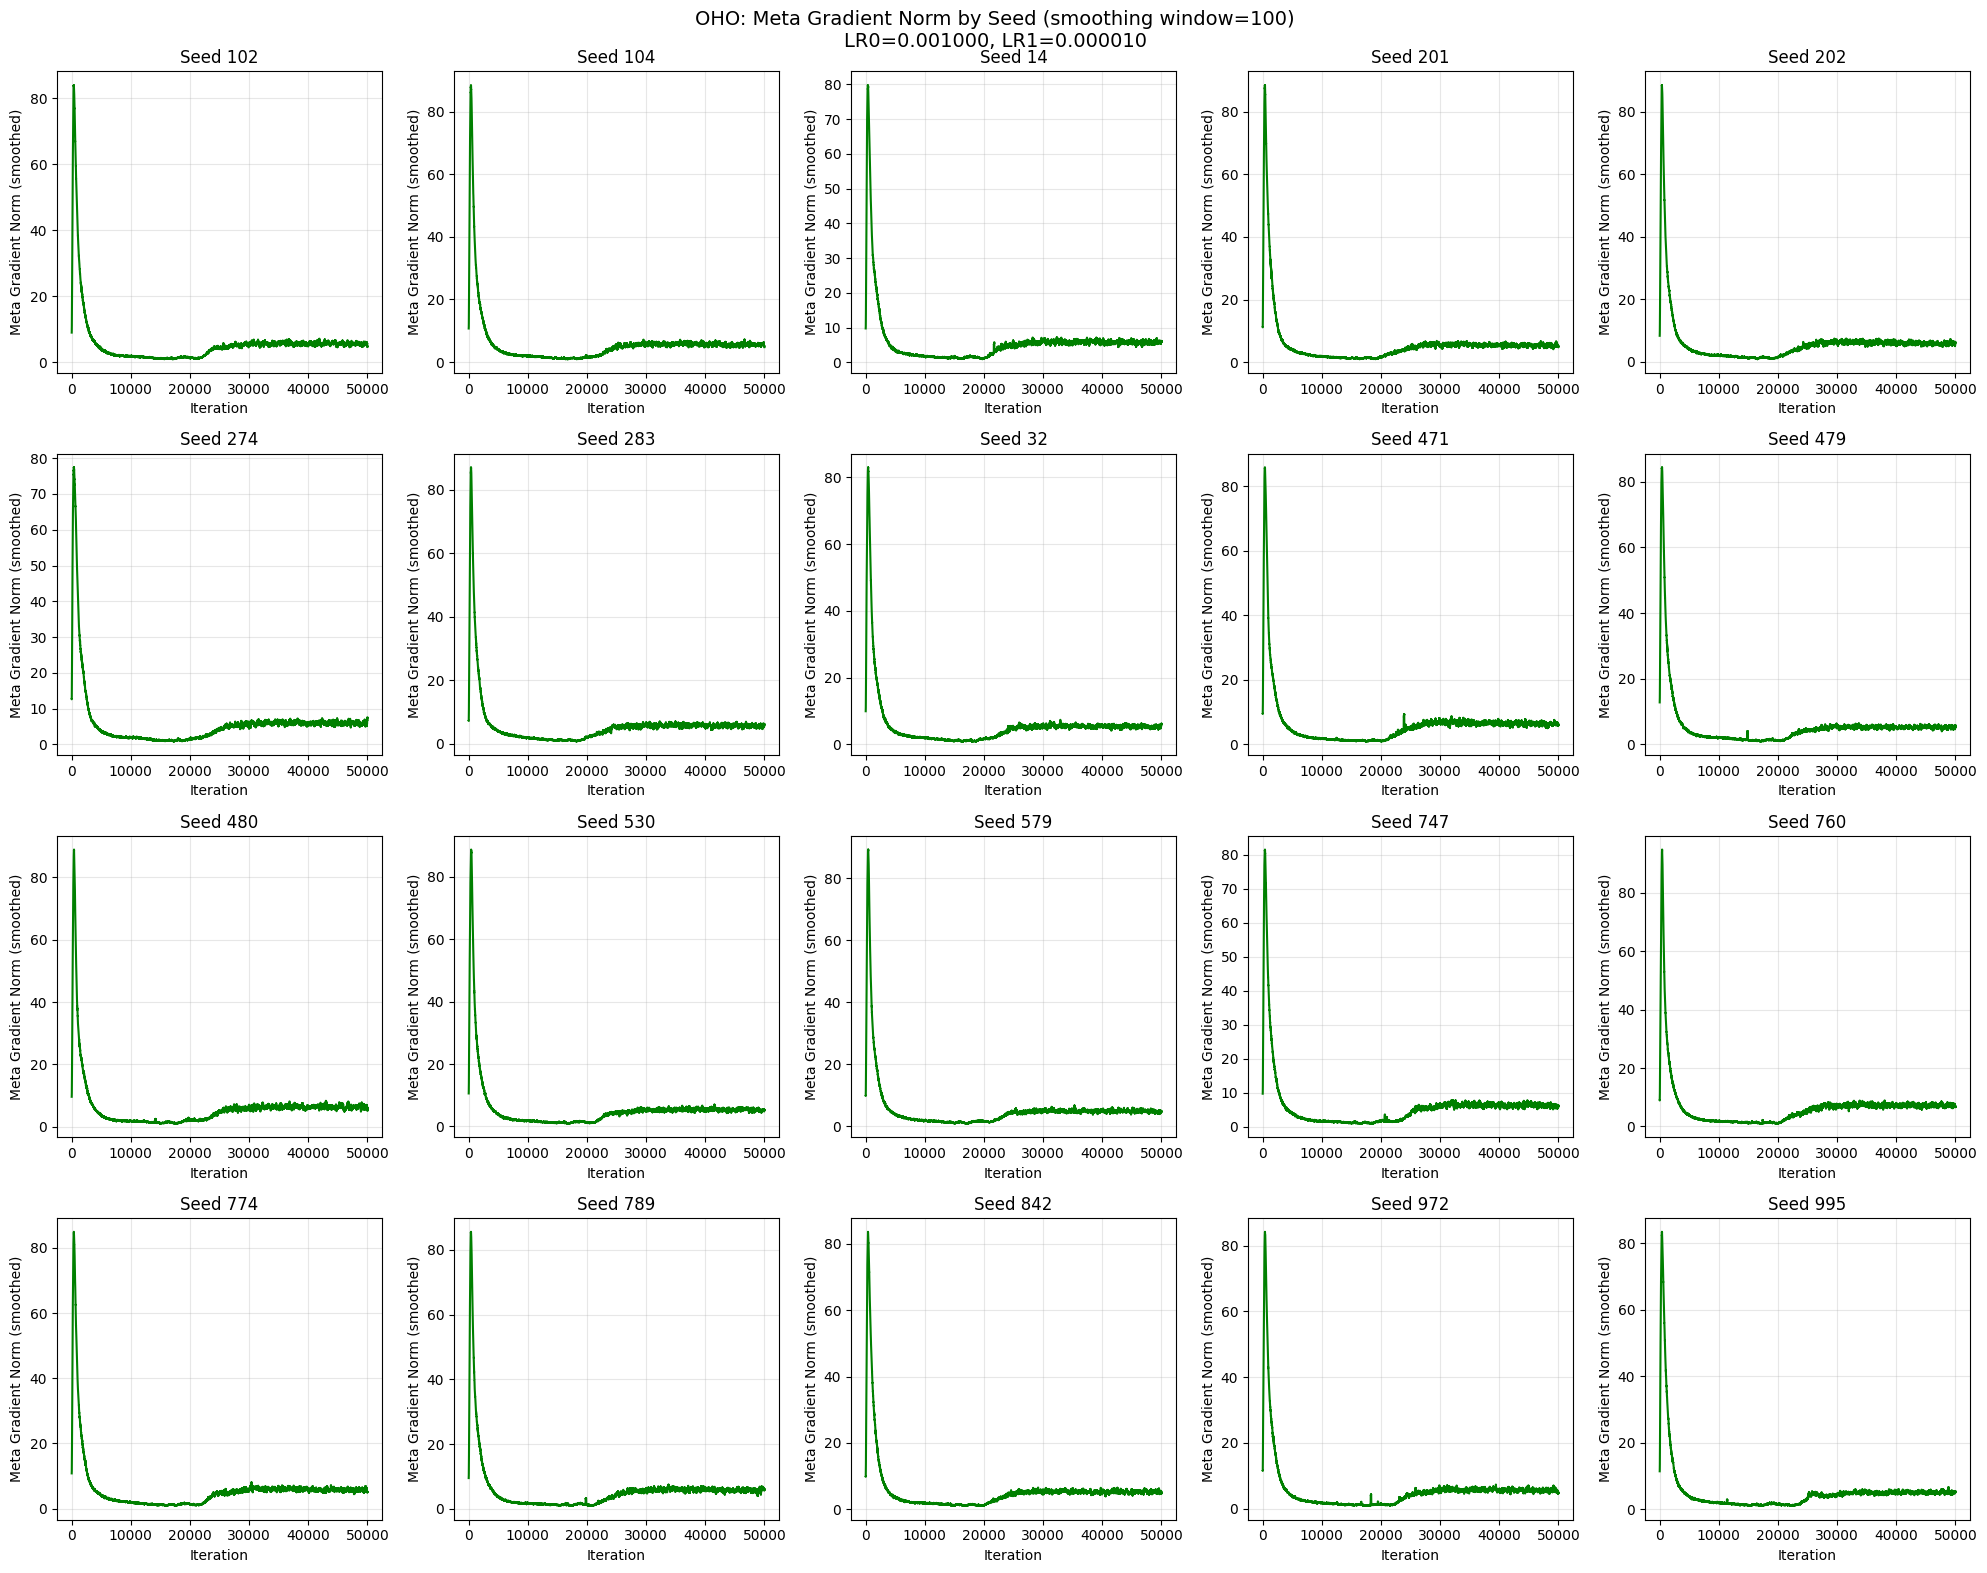

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter1d

def plot_meta_gradient_norm_by_seed(experiments, smooth_window=None):
    """
    Plot meta gradient norm curves for each seed individually.
    
    Args:
        experiments: list of tuples (name, df_metadata, df_timeseries)
        smooth_window: window size for smoothing, None for no smoothing
    """
    for name, df_metadata, df_timeseries in experiments:
        print(f"\nProcessing {name}...")
        
        metadata = df_metadata.compute()
        
        # Find best config
        lr_cols = ['config/learners/0/optimizer/learning_rate/value', 
                   'config/learners/1/optimizer/learning_rate/value']
        lr_summary = metadata.groupby(lr_cols)['metric/final_test_loss'].mean().reset_index()
        lr_summary = lr_summary.sort_values('metric/final_test_loss')
        best_config = lr_summary.iloc[0]
        best_lr0 = best_config[lr_cols[0]]
        best_lr1 = best_config[lr_cols[1]]
        
        print(f"  Best config: LR0={float(best_lr0):.6f}, LR1={float(best_lr1):.6f}")
        
        # Filter to best config
        best_metadata = metadata[
            (metadata[lr_cols[0]] == best_lr0) & 
            (metadata[lr_cols[1]] == best_lr1)
        ]
        
        # Get timeseries for best config
        timeseries = df_timeseries.compute()
        best_task_ids = best_metadata['task_id'].values
        best_timeseries = timeseries[timeseries['task_id'].isin(best_task_ids)]
        
        # Merge with metadata to get seeds
        best_timeseries_with_seed = best_timeseries.merge(
            best_metadata[['task_id', 'config/seed/global_seed']], 
            on='task_id'
        )
        
        # Get unique seeds
        seeds = sorted(best_timeseries_with_seed['config/seed/global_seed'].unique())
        print(f"  Number of seeds: {len(seeds)}")
        
        # Create subplots
        n_seeds = len(seeds)
        n_cols = 5
        n_rows = (n_seeds + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
        if n_rows == 1 and n_cols == 1:
            axes = np.array([[axes]])
        elif n_rows == 1:
            axes = axes.reshape(1, -1)
        elif n_cols == 1:
            axes = axes.reshape(-1, 1)
        
        # Plot meta gradient norm for each seed
        for idx, seed in enumerate(seeds):
            row = idx // n_cols
            col = idx % n_cols
            
            seed_data = best_timeseries_with_seed[
                best_timeseries_with_seed['config/seed/global_seed'] == seed
            ].sort_values('iteration')
            
            iterations = seed_data['iteration'].values
            meta_gradient_norms = seed_data['metric/meta_gradient_norm'].values
            
            # Apply smoothing if window specified
            if smooth_window is not None:
                plot_values = uniform_filter1d(meta_gradient_norms, size=smooth_window)
            else:
                plot_values = meta_gradient_norms
            
            axes[row, col].plot(iterations, plot_values, linewidth=1.5, color='green')
            axes[row, col].set_xlabel('Iteration')
            ylabel = 'Meta Gradient Norm' + (' (smoothed)' if smooth_window else '')
            axes[row, col].set_ylabel(ylabel)
            axes[row, col].set_title(f'Seed {int(seed)}')
            axes[row, col].grid(True, alpha=0.3)
        
        # Hide unused subplots
        for idx in range(n_seeds, n_rows * n_cols):
            row = idx // n_cols
            col = idx % n_cols
            axes[row, col].axis('off')
        
        title = f'{name}: Meta Gradient Norm by Seed'
        if smooth_window:
            title += f' (smoothing window={smooth_window})'
        title += f'\nLR0={float(best_lr0):.6f}, LR1={float(best_lr1):.6f}'
        fig.suptitle(title, fontsize=14)
        plt.tight_layout()
        plt.show()


plot_meta_gradient_norm_by_seed(experiments, smooth_window=100)